In [1]:
# required modules installation
from IPython import display
!pip install -q kaggle
!pip install -q kaggle-cli
!pip install category_encoders
display.clear_output()

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd

import warnings
warnings.filterwarnings("ignore")

# data upload

In [2]:
from google.colab import drive
drive.mount("/content/d")

Drive already mounted at /content/d; to attempt to forcibly remount, call drive.mount("/content/d", force_remount=True).


In [4]:
!mkdir -p ~/.kaggle
!cp d/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [5]:
!kaggle competitions download -c riiid-test-answer-prediction
!unzip riiid-test-answer-prediction.zip

100% 1.29G/1.29G [00:31<00:00, 65.1MB/s]
100% 1.29G/1.29G [00:31<00:00, 44.3MB/s]
Archive:  riiid-test-answer-prediction.zip
  inflating: example_sample_submission.csv  
  inflating: example_test.csv        
  inflating: lectures.csv            
  inflating: questions.csv           
  inflating: riiideducation/__init__.py  
  inflating: riiideducation/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: train.csv               


# research *train.csv* features

## technical research

In [26]:
# check the dataset size
train = dd.read_csv("train.csv")
sh = train.shape
print(f"dataset shape: {sh[0].compute()} rows, {sh[1]} columns")

dataset shape: 101230332 rows, 10 columns


In [27]:
# check the dataste columns types
print(train.dtypes)

row_id                              int64
timestamp                           int64
user_id                             int64
content_id                          int64
content_type_id                     int64
task_container_id                   int64
user_answer                         int64
answered_correctly                  int64
prior_question_elapsed_time       float64
prior_question_had_explanation     object
dtype: object


In [41]:
# check if the features values allow to lower dtype memory consumption
for feat in train:
    print(f"feature: {feat}")
    print(train[feat].value_counts().compute().iloc[:10])
    print()

feature: row_id
0           1
67486919    1
67486893    1
67486892    1
67486891    1
67486890    1
67486889    1
67486888    1
67486887    1
67486886    1
Name: row_id, dtype: int64

feature: timestamp
0        396417
24220        48
24163        48
25010        46
24072        46
24702        46
23587        46
24755        46
23823        46
24111        46
Name: timestamp, dtype: int64

feature: user_id
801103753     17917
1478712595    16914
1842816145    16851
455973631     16789
1660941992    16777
1743444187    16654
2146130037    16384
1047202059    16348
1615528747    16146
338684437     15963
Name: user_id, dtype: int64

feature: content_id
6116    213605
6173    202106
4120    199372
175     195861
7876    190170
7900    180858
2063    176043
2064    176043
2065    176043
4492    173769
Name: content_id, dtype: int64

feature: content_type_id
0    99271300
1     1959032
Name: content_type_id, dtype: int64

feature: task_container_id
14    804285
15    798539
4     692079
5 

In [3]:
# decrease RAM consumption throught features dtype
# and read by pandas
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "boolean"
}

train = pd.read_csv("train.csv", dtype=dtypes)

empty values for the feature row_id: 0.0%
empty values for the feature timestamp: 0.0%
empty values for the feature user_id: 0.0%
empty values for the feature content_id: 0.0%
empty values for the feature content_type_id: 0.0%
empty values for the feature task_container_id: 0.0%
empty values for the feature user_answer: 0.0%
empty values for the feature answered_correctly: 0.0%
empty values for the feature prior_question_elapsed_time: 2.38%
empty values for the feature prior_question_had_explanation: 0.39%


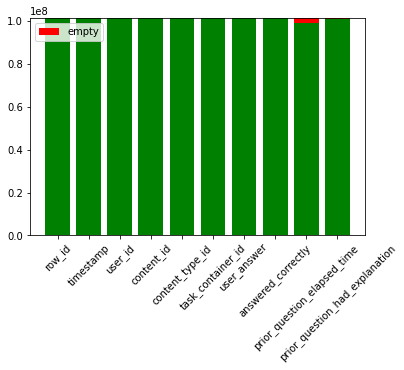

In [72]:
labels = train.columns
naS = [train[f].isna().sum() for f in train]
fld = [len(train) - train[f].isna().sum() for f in train]

for i in range(len(train.columns)):
    print(f"empty values for the feature {train.columns[i]}: {round(naS[i] / fld[i] * 100, 2)}%")

plt.xticks(rotation=45)
plt.bar(labels, fld, color="green")
plt.bar(labels, naS, bottom=fld, color="red", label="empty")
plt.legend();

### timestamp

The feature *'timestamp'* is the time between the user interaction and the event completion in miliseconds. To get the general understanding of the time period the data should be converted to the regular units:

In [14]:
# check the median value in other units
print(
    f"the mode of the timestamp is {int(train.timestamp.describe()['50%'] / (1000 * 60 * 60))} hours "\
    f"or {int(train.timestamp.describe()['50%'] / (1000 * 60 * 60 * 24))} days"
)

the mode of the timestamp is 742 hours or 30 days


Let's visualize the timestamp in months:

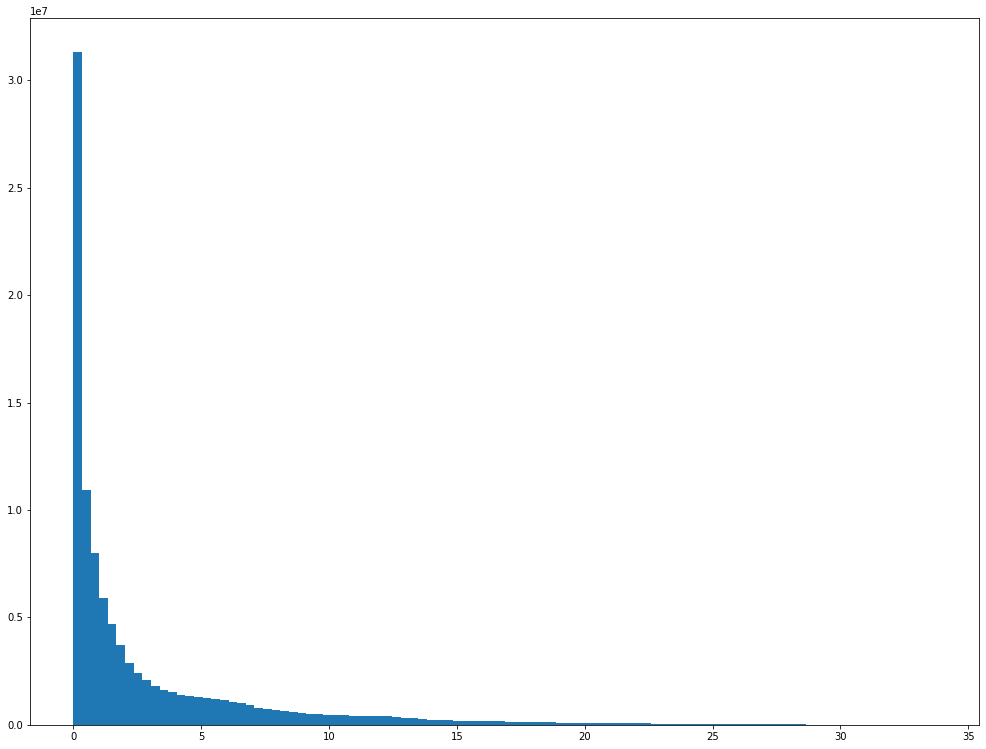

In [7]:
plt.figure(figsize=(17,13))
plt.hist(train.timestamp/(1000 * 60 * 60 * 24 * 30), bins=100);

Significant amount of interactions covers the first year quater.

### user_id

In [15]:
print(
    f"number of the unique users: {train.user_id.nunique():,},\n"\
    f"that is {int(len(train) / train.user_id.nunique())} interaction per user in average"
)

number of the unique users: 393,656,
that is 257 interaction per user in average


### content_id and content_type_id

All user interactions can be classified as question or lecture:

In [30]:
questions_id = train[train.content_type_id == 0].content_id.unique().tolist()
lectures_id = train[train.content_type_id == 1].content_id.unique().tolist()
print(
    f"number of questions interaction type: {len(questions_id)},\n"\
    f"that is {int(len(questions_id)/train.content_id.nunique())*100}% of all interacton type,\n"\
    f"number of lectures interaction type: {len(lectures_id)}"
)

number of questions interaction type: 13523,
that is 0% of all interacton type,
number of lectures interaction type: 415


In [3]:
print(f"top 10 most popular questions:")
train[train.content_type_id == 0].content_id.value_counts().iloc[:10]

top 10 most popular questions:


6116    213605
6173    202106
4120    199372
175     195861
7876    190170
7900    180858
2063    176043
2065    176043
2064    176043
4492    173769
Name: content_id, dtype: int64

In [5]:
print(f"top 10 most popular lectures:")
train[train.content_type_id == 1].content_id.value_counts().iloc[:10]

top 10 most popular lectures:


3153     37024
21411    27051
10540    24312
29695    24126
15888    22627
27845    21250
26335    21118
32312    20943
29544    20941
18545    19167
Name: content_id, dtype: int64

### *'user_answer'*

In [7]:
print(f"the distribution of the users answers:")
train.user_answer.value_counts()

the distribution of the users answers:


 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

Excluding "-1" for the lectures the answers are more or less evenly distributed except for the answer "2". 

### *'answered_correctly'*

In [7]:
excl_lect = len(train[train.answered_correctly != -1])
cor = train.answered_correctly.value_counts()[1]
incor = train.answered_correctly.value_counts()[0]
print(
    f"the distribution of the correct answers excluding lectures:\n"\
    f"correct answes {cor:,}, {int(cor/excl_lect*100)}%\n"
    f"incorrect answes {incor:,}, {int(incor/excl_lect*100)}%\n"
)

the distribution of the correct answers excluding lectures:
correct answes 65,244,627, 65%
incorrect answes 34,026,673, 34%



## content research

### answered correctly vs time of interaction
Test the assumption of the depedency correct answers and time of interaction. The timestamp is divided unevenly: day, week, month, year, >1 year:

In [20]:
day = 1000 * 60 * 60 * 24
week = day * 7
month = day * 30
year = day * 365

day_a = int(train[train.timestamp < day].answered_correctly.value_counts()[1] \
            / len(train[(train.timestamp < day) & (train.answered_correctly != -1)])*100)
week_a = int(train[(train.timestamp < week)].answered_correctly.value_counts()[1] \
             / len(train[(train.timestamp < week) & (train.answered_correctly != -1)])*100)
month_a = int(train[(train.timestamp < month)].answered_correctly.value_counts()[1] \
             / len(train[(train.timestamp < month) & (train.answered_correctly != -1)])*100)
year_a = int(train[(train.timestamp < year)].answered_correctly.value_counts()[1] \
             / len(train[(train.timestamp < year) & (train.answered_correctly != -1)])*100)
long_a = int(train[(train.timestamp >= year)].answered_correctly.value_counts()[1] \
             / len(train[(train.answered_correctly != -1)])*100)

print(
    f"correct to incorrect answers within:\n"\
    f"a day {day_a}%\n"\
    f"a week {week_a}%\n"\
    f"a month {month_a}%\n"\
    f"a year {year_a}%\n"\
    f"of the correct answers\n"\
)

correct to incorrect answers within:
a day 55%
a week 60%
a month 63%
a year 65%
of the correct answers



The general dependency - the longer a user is a the platform the better score he/she gets.

### the percent of the correct answers vs first question bundle

The assumption here is if I can generate a new feature - the first question. If the correct answers share statistically differs this might be a good feature. 

In [28]:
# drop the lecture to get the first bundlge question
fq = train[(train.content_type_id == 0)&(train.prior_question_elapsed_time == 0)].answered_correctly.value_counts()
print(f"{int(fq[1] / fq.sum()*100)}% vs 65% in average")

61% vs 65% in average


The number of correct answers for the first bundle questions doesn't differ much from the average.

### the percent of the correct answers vs prior question 

In [33]:
he = train[train.prior_question_had_explanation == 1].answered_correctly.value_counts()
hen = train[train.prior_question_had_explanation == 0].answered_correctly.value_counts()
print(
    f"share of the correct answers if a question had an explanation: "\
    f"{int(he[1]/he.sum()*100)}%"
)
print(
    f"share of the correct answers if a question had no explanation: "\
    f"{int(hen[1]/hen.sum()*100)}%"
)

share of the correct answers if a question had an explanation: 67%
share of the correct answers if a question had no explanation: 41%


## feature importance

Quick research for features importance though linear (logistic regression)dependency. Due to low RAM the dataset will be sampled for 10% of the initial size. 

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [5]:
train = train.sample(n=int(len(train)*0.1)).reset_index(drop=True)

In [6]:
# fill empty values
train.prior_question_elapsed_time.fillna(-1, inplace=True)

In [7]:
train = train.replace({"prior_question_had_explanation": {True: 1, False: 0}})
train.prior_question_had_explanation.fillna(-1, inplace=True)

In [8]:
# encode categorical features
to_drop = ["row_id", "user_id"]
categoricals = ["content_id", "content_type_id", "task_container_id", "user_answer"]

import category_encoders

encoder = category_encoders.target_encoder.TargetEncoder(return_df=False)
train = train.drop(to_drop, axis=1)
encoder.fit(train[categoricals], train.answered_correctly)
train[categoricals] = encoder.transform(train[categoricals].copy().values)

In [9]:
# data scaling
scaler = StandardScaler()
scaler.fit(train.drop("answered_correctly", axis=1), train.answered_correctly)
train = pd.concat([
    pd.DataFrame(
        scaler.transform(train.drop("answered_correctly", axis=1)),
            columns = train.drop("answered_correctly", axis=1).columns
        ).reset_index(drop=True),
        train["answered_correctly"].reset_index(drop=True)], axis=1)

1 / 7


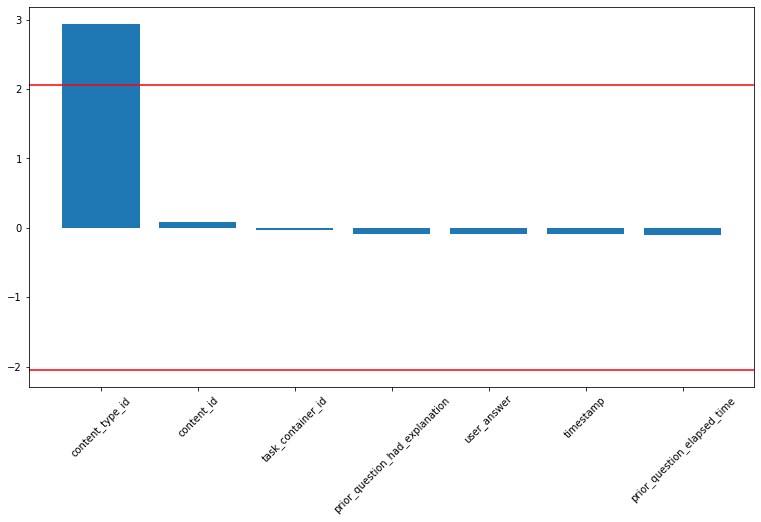

In [10]:
# linear dependency
model = LogisticRegression()
model.fit(
    train.drop("answered_correctly", axis=1), 
    train.answered_correctly
)
importances_logreg = pd.DataFrame(data={
    'feature': train.drop("answered_correctly", axis=1).columns,
    'value': model.coef_[0]
})
importances_logreg = importances_logreg.sort_values(by='value', ascending=False)


k = 0.7
mi_logreg = importances_logreg[importances_logreg.value.abs() > importances_logreg.value.abs().max()*k] 
print(len(mi_logreg),"/",len(importances_logreg))

if True:
    plt.figure(figsize=(13, 7))
    plt.xticks(rotation=45)
    plt.axhline(importances_logreg.value.abs().max()*k, color="r")
    plt.axhline(-importances_logreg.value.abs().max()*k, color="r")
    plt.bar(
        x=importances_logreg.feature,
        height=importances_logreg.value
    )

Based on the linear dependency the most important feature is the content type.

# research *question.csv* features

In [13]:
quest = pd.read_csv("questions.csv")
print(f"shape: {quest.shape}")
quest.head()

shape: (13523, 5)


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [16]:
# check nas
quest.isna().sum()

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

In [31]:
print(f"total number of questions: {quest.question_id.values[-1]+1}")

total number of questions: 13523


Get the list of all tags:

In [24]:
all_tags = sorted(list(set([x for sl in quest.tags.apply(lambda v: v.split(" ") if v == v else "-1").values for x in sl])))
print(all_tags)

['-', '0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '

In [30]:
# check if the tags list is a numeric range
sorted([int(x) for x in all_tags if x != "-"]) == list(range(0, 188))

True

So the tags are tne integer numeric values from 0 to 187, 188 in total.

# research *lectures.csv* features

In [33]:
lectures = pd.read_csv("lectures.csv")
print(f"shape: {lectures.shape}")
lectures.head()

shape: (418, 4)


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [35]:
print(f"total number of lectures: {lectures.lecture_id.nunique()}")
lectures.lecture_id.unique()

total number of lectures: 418


array([   89,   100,   185,   192,   317,   335,   484,   641,   761,
         814,  1003,  1077,  1105,  1144,  1253,  1308,  1450,  1501,
        1604,  1731,  1887,  1907,  1967,  2033,  2049,  2084,  2278,
        2282,  2299,  2327,  2476,  2771,  2857,  2904,  2918,  3078,
        3113,  3123,  3153,  3255,  3625,  3668,  3697,  3780,  3803,
        3852,  3879,  3937,  4057,  4072,  4100,  4118,  4173,  4187,
        4385,  4425,  4441,  4652,  4705,  4883,  5120,  5240,  5266,
        5588,  5694,  5752,  5990,  6081,  6101,  6137,  6220,  6316,
        6481,  6619,  6761,  6797,  6808,  6948,  7008,  7010,  7097,
        7385,  7477,  7704,  7785,  7877,  7920,  7926,  7949,  8138,
        8207,  8233,  8240,  8288,  8317,  8320,  8330,  8411,  8461,
        8513,  8693,  8708,  8821,  8976,  8977,  9174,  9212,  9245,
        9477,  9554,  9758,  9831,  9835,  9856,  9896, 10010, 10032,
       10040, 10052, 10075, 10180, 10217, 10354, 10382, 10383, 10540,
       10688, 10742,

(array([2., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
 array([  3. ,  24.9,  46.8,  68.7,  90.6, 112.5, 134.4, 156.3, 178.2,
        200.1, 222. ]),
 <a list of 10 Patch objects>)

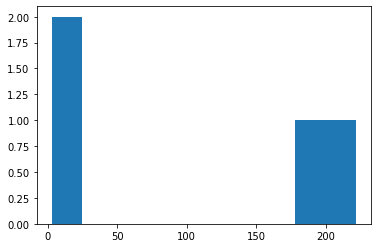

In [55]:
plt.hist(lectures.type_of.value_counts().values)

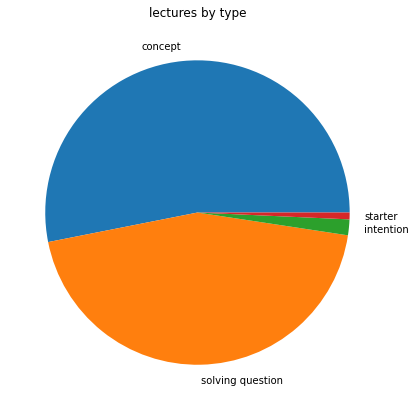

In [61]:
plt.figure(figsize=(13,7))
plt.title("lectures by type")
plt.pie(lectures.type_of.value_counts(), labels=lectures.type_of.value_counts().keys())
plt.show()

In [44]:
# check if the tags are the same as in the questions
sorted(lectures.tag.unique()) == list(range(0, 188))

False

In [47]:
# check whick tags differ
print([x for x in sorted(lectures.tag.unique()) if x not in list(range(0, 188))])
print([x for x in list(range(0, 188)) if x not in sorted(lectures.tag.unique())])

[]
[3, 10, 11, 21, 22, 29, 32, 35, 38, 41, 46, 56, 59, 63, 77, 81, 84, 86, 87, 88, 92, 100, 102, 107, 110, 117, 121, 122, 131, 135, 146, 154, 160, 162, 165, 185, 186]


Not all the question tags are covered by lectures.